In [ ]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Flatten, Dense, Input, Reshape, LeakyReLU, BatchNormalization, UpSampling2D, Dropout
from keras.callbacks import LambdaCallback
import numpy as np

In [209]:
from keras.preprocessing.image import ImageDataGenerator

# Autoencoder

In [216]:
BATCH_AE = 64
EPOCHS_AE = 20

In [217]:
src_path_train = "data\\train"

train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.10)

In [218]:
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='input'  # делает так, чтобы и x, и y были x
)
val_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='input'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [320]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1124841186425668085
xla_global_id: -1
]


In [379]:
a = next(iter(train_generator))

# Построение модели

In [398]:
# encoder = Sequential([
#     Input(shape=(64, 64, 3)),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     Flatten(), 
#     Dense(1536, activation='leaky_relu')
# ])

# decoder = Sequential([
#     Input(shape=(1536,)),
#     Dense(2048, activation='leaky_relu'),
#     Reshape((8, 8, 32)),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
# ])


# encoder = Sequential([
#     Input(shape=(64, 64, 3)),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
#     MaxPool2D((2, 2), padding='same'),
#     Flatten(),
#     Dense(1024, activation='leaky_relu')
# ])

# decoder = Sequential([
#     Input(shape=(1024,)),
#     Dense(2048, activation='leaky_relu'),
#     Reshape((8, 8, 32)),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
#     Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
# ])
# autoencoder = Sequential([encoder, decoder])

# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.build(input_shape=(None, 64,64,3))
# autoencoder.summary()

encoder = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='leaky_relu', padding='same'),
    MaxPool2D((2, 2), padding='same'),
    Flatten(),
    Dense(2048, activation='leaky_relu'),
    Dense(1024, activation='leaky_relu'),
])

decoder = Sequential([
    Input(shape=(1024,)),
    Dense(2048, activation='leaky_relu'),
    Reshape((8, 8, 32)),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='leaky_relu', padding='same'),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
])
autoencoder = Sequential([encoder, decoder])

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.build(input_shape=(None, 64,64,3))
autoencoder.summary()

Model: "sequential_195"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_193 (Sequential  (None, 1024)              18887584  
 )                                                               
                                                                 
 sequential_194 (Sequential  (None, 64, 64, 3)         2127811   
 )                                                               
                                                                 
Total params: 21015395 (80.17 MB)
Trainable params: 21015395 (80.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [399]:
#encoder(a[0]).shape
#decoder(encoded).shape
# autoencoder(image) # batch, width, heigth, channels

In [400]:
save_weights_epochs = [1, 2, 4, 8, 16]
WeightsSaver = lambda model, name, eps: LambdaCallback(
    on_epoch_end=lambda epoch, _: model.save_weights('{}_{}.h5'.format(name, epoch + 1)) \
        if epoch + 1 in eps else None)

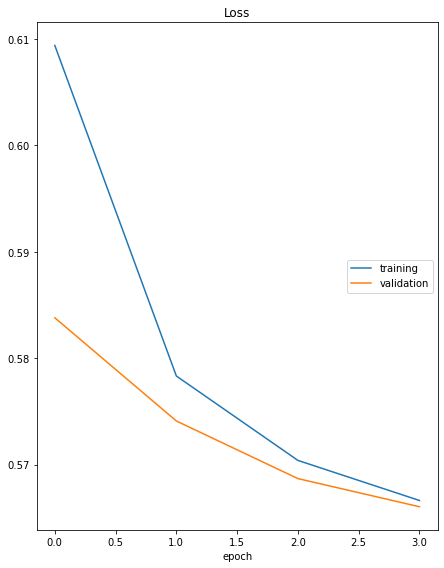

Loss
	training         	 (min:    0.567, max:    0.609, cur:    0.567)
	validation       	 (min:    0.566, max:    0.584, cur:    0.566)
352/352 [==============================] - 208s 591ms/step - loss: 0.5666 - val_loss: 0.5660
Epoch 5/20
335/352 [===========================>..] - ETA: 9s - loss: 0.5647 

In [401]:
from keras.callbacks import LambdaCallback
from livelossplot import PlotLossesKeras

history = autoencoder.fit(
    train_generator,
    epochs=EPOCHS_AE,
    validation_data=val_generator,
    callbacks=[PlotLossesKeras(), WeightsSaver(
                    autoencoder, "autoencoder", save_weights_epochs)]
)

In [394]:
example = a[0][16,:,:,:]

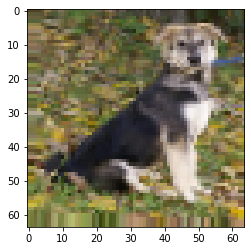

In [395]:
plt.imshow(example)

In [396]:
output = autoencoder(np.array([example]))

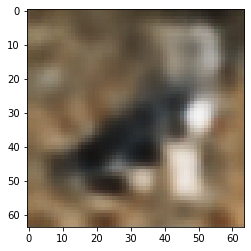

In [397]:
plt.imshow(output[0,:,:,:])

# Классификатор

Выгружаю данные для обучения классификатора(надо чтоб X и y теперь были разные)

In [205]:
train_generator_class = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='training',
    shuffle=True,
    seed=42,
    class_mode='binary' 
)
val_generator_class = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=BATCH_AE,
    subset='validation',
    shuffle=False,
    seed=42,
    class_mode='binary'
)

Found 22497 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [200]:
a = next(iter(train_generator_class))
a

(array([[[[1.23417385e-01, 1.71400592e-01, 7.80812204e-02],
          [1.03447378e-01, 1.71737373e-01, 3.38053517e-02],
          [5.94998412e-02, 1.22808531e-01, 1.34436963e-02],
          ...,
          [4.81777966e-01, 4.69490021e-01, 4.07128274e-01],
          [4.89473104e-01, 4.57947254e-01, 3.90455395e-01],
          [4.97168303e-01, 4.77419198e-01, 3.94628465e-01]],
 
         [[1.18269399e-01, 1.63678601e-01, 8.45162123e-02],
          [1.18891351e-01, 1.76885352e-01, 5.56843095e-02],
          [7.49438107e-02, 1.51122466e-01, 7.00870901e-03],
          ...,
          [5.03815174e-01, 5.35025001e-01, 4.25646961e-01],
          [5.11510313e-01, 6.01716578e-01, 4.61557806e-01],
          [5.14010847e-01, 6.51005983e-01, 4.88637716e-01]],
 
         [[1.17047980e-01, 1.59279108e-01, 9.18573216e-02],
          [1.27770588e-01, 1.77930400e-01, 7.26397187e-02],
          [9.03877765e-02, 1.67384163e-01, 1.53042488e-02],
          ...,
          [4.98501569e-01, 6.34388924e-01, 4.8199

In [201]:
encoder.trainable = False

In [206]:
densenet = Sequential([
    encoder,
    Input(shape=(1024, 1)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

densenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

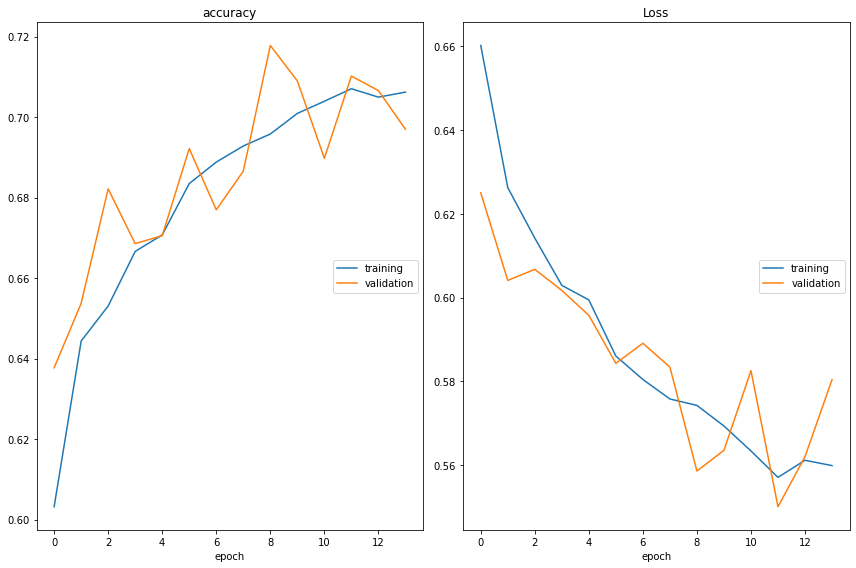

accuracy
	training         	 (min:    0.603, max:    0.707, cur:    0.706)
	validation       	 (min:    0.638, max:    0.718, cur:    0.697)
Loss
	training         	 (min:    0.557, max:    0.660, cur:    0.560)
	validation       	 (min:    0.550, max:    0.625, cur:    0.580)
352/352 [==============================] - 88s 251ms/step - loss: 0.5599 - accuracy: 0.7062 - val_loss: 0.5804 - val_accuracy: 0.6970
Epoch 15/20
 41/352 [==>...........................] - ETA: 1:33 - loss: 0.5559 - accuracy: 0.7138

KeyboardInterrupt: 

In [207]:
densenet.fit(train_generator_class,
              epochs=20,
              shuffle=True,
              validation_data=val_generator_class,
              callbacks=[PlotLossesKeras()])